In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *

In [ ]:
#default_exp callback.schedule

# Hyperparam schedule

> Callback and helper functions to schedule any hyper-parameter

In [ ]:
from local.utils.test import *

## Annealing

In [ ]:
#export
def annealer(f):
    "Decorator to make `f` return itself partially applied."
    @functools.wraps(f)
    def _inner(start, end): return partial(f, start, end)
    return _inner

This is the decorator we will use for all of our scheduling functions, as it transforms a function taking `(start, end, pos)` to something taking `(start, end)` and return a function depending of `pos`.

In [ ]:
#export
@annealer
def SchedLin(start, end, pos): return start + pos*(end-start)
@annealer
def SchedCos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def SchedNo (start, end, pos): return start
@annealer
def SchedExp(start, end, pos): return start * (end/start) ** pos

SchedLin.__doc__ = "Linear schedule function from `start` to `end`"
SchedCos.__doc__ = "Cosine schedule function from `start` to `end`"
SchedNo .__doc__ = "Constant schedule function with `start` value"
SchedExp.__doc__ = "Exponential schedule function from `start` to `end`"

In [ ]:
#export
def SchedPoly(start, end, power): 
    "Polynomial schedule (of `power`) function from `start` to `end`"
    def _inner(pos): return start + (end - start) * pos ** power
    return _inner

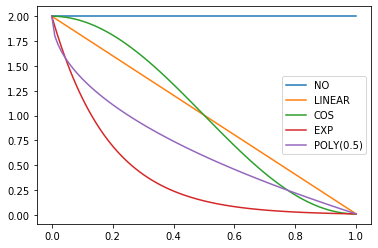

In [ ]:
annealings = "NO LINEAR COS EXP".split()

p = torch.linspace(0.,1,100)

fns = [SchedNo, SchedLin, SchedCos, SchedExp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(p, [f(o) for o in p], label=t)
f = SchedPoly(2,1e-2,0.5)
plt.plot(p, [f(o) for o in p], label="POLY(0.5)")
plt.legend();

In [ ]:
show_doc(SchedLin)

<h4 id="SchedLin" class="doc_header"><code>SchedLin</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/14_callback_schedule.ipynb#Annealing" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedLin</code>(**`start`**, **`end`**, **`pos`**)

Linear schedule function from `start` to `end`

In [ ]:
sched = SchedLin(0, 2)
test_eq(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.5, 1., 1.5, 2.])

In [ ]:
show_doc(SchedCos)

<h4 id="SchedCos" class="doc_header"><code>SchedCos</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/14_callback_schedule.ipynb#Annealing" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedCos</code>(**`start`**, **`end`**, **`pos`**)

Cosine schedule function from `start` to `end`

In [ ]:
sched = SchedCos(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.29289, 1., 1.70711, 2.])

In [ ]:
show_doc(SchedNo)

<h4 id="SchedNo" class="doc_header"><code>SchedNo</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/14_callback_schedule.ipynb#Annealing" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedNo</code>(**`start`**, **`end`**, **`pos`**)

Constant schedule function with `start` value

In [ ]:
sched = SchedNo(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0., 0., 0., 0.])

In [ ]:
show_doc(SchedExp)

<h4 id="SchedExp" class="doc_header"><code>SchedExp</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/14_callback_schedule.ipynb#Annealing" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedExp</code>(**`start`**, **`end`**, **`pos`**)

Exponential schedule function from `start` to `end`

In [ ]:
sched = SchedExp(1, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [1., 1.18921, 1.41421, 1.68179, 2.])

In [ ]:
show_doc(SchedPoly)

<h4 id="SchedPoly" class="doc_header"><code>SchedPoly</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/14_callback_schedule.ipynb#Annealing" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedPoly</code>(**`start`**, **`end`**, **`power`**)

Polynomial schedule (of `power`) function from `start` to `end`

In [ ]:
sched = SchedPoly(0, 2, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.125, 0.5, 1.125, 2.])

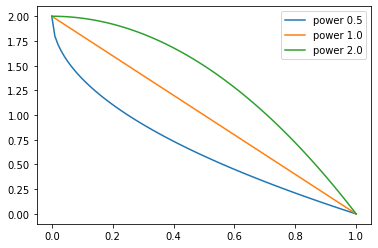

In [ ]:
p = torch.linspace(0.,1,100)

pows = [0.5,1.,2.]
for e in pows:
    f = SchedPoly(2, 0, e)
    plt.plot(p, [f(o) for o in p], label=f'power {e}')
plt.legend();

In [ ]:
#export
def combine_scheds(pcts, scheds):
    "Combine `scheds` according to `pcts` in one function"
    assert sum(pcts) == 1.
    pcts = tensor([0] + L(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        if pos == 1.: return scheds[-1](1.)
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

`pcts` must be a list of positive numbers that add up to 1 and is the same length as `scheds`. The generated function will use `scheds[0]` from 0 to `pcts[0]` then `scheds[1]` from `pcts[0]` to `pcts[0]+pcts[1]` and so forth.

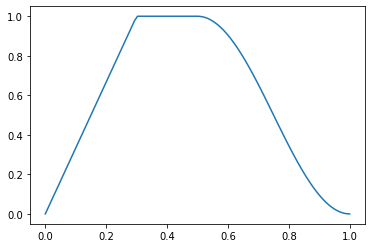

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3,0.2,0.5], [SchedLin(0.,1.), SchedNo(1.,1.), SchedCos(1., 0.)])
plt.plot(p, [f(o) for o in p]);

In [ ]:
#hide
test_close([f(0.), f(0.15), f(0.3), f(0.4), f(0.5), f(0.7), f(1.)],
           [0., 0.5, 1., 1., 1., 0.65451, 0.])

In [ ]:
#export
def combined_cos(pct, start, middle, end):
    "Return a combined scheduler with cosine annealing from `start` to `middle` then `middle` to `end`"
    if is_listy(start): 
        return [combine_scheds([pct,1-pct], [SchedCos(s, m), SchedCos(m, e)]) 
                for s,m,e in zip(start,middle,end)] 
    return combine_scheds([pct,1-pct], [SchedCos(start, middle), SchedCos(middle, end)])

This is a useful helper function for the 1cycle policy. `pct` is used for the `start` to `middle` part, `1-pct` for the `middle` to `end`. Handles floats or collection of floats.

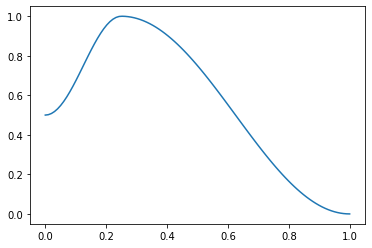

In [ ]:
p = torch.linspace(0.,1,100)
f = combined_cos(0.25,0.5,1.,0.)
plt.plot(p, [f(o) for o in p]);

In [ ]:
#hide
test_close([f(0.), f(0.1), f(0.25), f(0.5), f(1.)], [0.5, 0.67275, 1., 0.75, 0.])
fs = combined_cos(0.25, [0.25,0.5], [0.5,1.], [0.,0.])
test_eq(len(fs), 2)
f,g = fs
test_close([f(0.), f(0.1), f(0.25), f(0.5), f(1.)], [0.25, 0.33638, 0.5, 0.375, 0.])
test_close([g(0.), g(0.1), g(0.25), g(0.5), g(1.)], [0.5, 0.67275, 1., 0.75, 0.])

## ParamScheduler -

In [ ]:
#export
@docs
class ParamScheduler(Callback):
    "Schedule hyper-parameters according to `scheds`"
    run_after=TrainEvalCallback
    
    def __init__(self, scheds): self.scheds = scheds
        
    def begin_fit(self): self.hps = {p:[] for p in self.scheds.keys()}

    def _update_val(self, pct):
        for pname,fs in self.scheds.items():
            fs = L(fs)
            if len(fs)==1: fs = fs*len(self.opt.param_groups)
            for f,h in zip(fs,self.opt.hypers): h[pname] = f(pct)
    
    def begin_batch(self):
        if not self.training: return
        self._update_val(self.pct_train)
    
    def after_batch(self):
        if self.training:
            for p in self.scheds.keys(): self.hps[p].append(self.opt.hypers[-1][p])
    
    def after_fit(self):
        if hasattr(self.learn, 'recorder'): self.recorder.hps = self.hps
            
    _docs = {"begin_fit": "Initialize container for hyper-parameters",
             "begin_batch": "Set the proper hyper-parameters in the optimizer",
             "after_batch": "Record hyper-parameters of this batch",
             "after_fit": "Save the hyper-parameters in the recorder if there is one"}

`scheds` is a dictionary with one key for each hyper-parameter you want to schedule, with either a scheduler or a list of schedulers as values (in the second case, the list must have the same length as the the number of parameters groups of the optimizer).

In [ ]:
learn = synth_learner()
sched = {'lr': SchedLin(1e-3, 1e-2)}
learn.fit(1, cbs=ParamScheduler(sched))
n = len(learn.data.train_dl)
test_close(learn.recorder.hps['lr'], [1e-3 + (1e-2-1e-3) * i/n for i in range(n)])

RecursionError: maximum recursion depth exceeded

In [ ]:
show_doc(ParamScheduler.begin_fit)

In [ ]:
show_doc(ParamScheduler.begin_batch)

In [ ]:
show_doc(ParamScheduler.after_batch)

In [ ]:
show_doc(ParamScheduler.after_fit)

In [ ]:
#export
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, 
                  moms=(0.95,0.85,0.95), cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    lr_max = lr_max or self.lr
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final), 
              'mom': combined_cos(pct_start, *moms)}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt)

The 1cycle policy was introduce by Leslie N. Smith et al. in [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120). This schedules the learning rate with a cosine annealing from `lr_max/div` to `lr_max` then `lr_max/div_final` (pass an array to `lr_max` if you want to use differential learning rates) and the momentum with cosine annealing according to the values in `moms`. The first phase takes `pct_start` of the training. You can optionally pass additional `cbs` and `reset_opt`.

In [ ]:
#Integration test: training a few epochs should make the model better
learn = synth_learner()
xb,yb = learn.data.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit_one_cycle(2)
assert learn.loss < init_loss

In [ ]:
#Scheduler test
lrs,moms = learn.recorder.hps['lr'],learn.recorder.hps['mom']
test_close(lrs,  [combined_cos(0.25,1e-2/25,1e-2,1e-7)(i/20) for i in range(20)])
test_close(moms, [combined_cos(0.25,0.95,0.85,0.95)(i/20) for i in range(20)])

In [ ]:
#export
@patch
def plot_sched(self:Recorder, figsize=None):
    rows,cols = (len(self.hps)+1)//2, min(2, len(self.hps))
    figsize = figsize or (6*cols,4*rows)
    _, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.flatten() if len(self.hps) > 1 else L(axs)
    for p,ax in zip(self.hps.keys(), axs):
        ax.plot(self.hps[p])
        ax.set_ylabel(p)

In [ ]:
learn = synth_learner()
learn.fit_one_cycle(2)

In [ ]:
learn.recorder.plot_sched()

In [ ]:
#export
@patch
def fit_sgdr(self:Learner, n_cycles, cycle_len, lr_max=None, cycle_mult=2, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_cycles` of `cycle_len` using SGDR."
    lr_max = lr_max or self.lr
    n_epoch = cycle_len * (cycle_mult**n_cycles-1)//(cycle_mult-1)
    pcts = [cycle_len * cycle_mult**i / n_epoch for i in range(n_cycles)]
    scheds = [SchedCos(lr_max, 0) for _ in range(n_cycles)]
    scheds = {'lr': combine_scheds(pcts, scheds)}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt)

This schedule was introduced by Ilya Loshchilov et al. in [SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983). It consists of `n_cycles` that are cosine annealings from `lr_max` (defaults to the `Learner` lr) to 0, with a length of `cycle_len * cycle_mult**i` for the `i`-th cycle (first one is `cycle_len`-long, then we multiply the length by `cycle_mult` at each epoch). You can optionally pass additional `cbs` and `reset_opt`.

In [ ]:
#slow
learn = synth_learner()
with learn.no_logging(): learn.fit_sgdr(3, 1)
test_eq(learn.n_epoch, 7)
iters = [k * len(learn.data.train_dl) for k in [0,1,3,7]]
for i in range(3):
    n = iters[i+1]-iters[i]
    #The start of a cycle can be mixed with the 0 of the previous cycle with rounding errors, so we test at +1
    test_close(learn.recorder.lrs[iters[i]+1:iters[i+1]], [SchedCos(learn.lr, 0)(k/n) for k in range(1,n)])

learn.recorder.plot_sched()

## LRFind -

In [ ]:
#export
@docs
class LRFinder(ParamScheduler):
    "Training with exponentially growing learning rate"
    run_after=Recorder
    
    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True): 
        if is_listy(start_lr):
            self.scheds = {'lr': [SchedExp(s, e) for (s,e) in zip(start_lr,end_lr)]}
        else: self.scheds = {'lr': SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div = num_it,stop_div
    
    def begin_fit(self):
        super().begin_fit()
        self.best_loss = float('inf')
    
    def begin_batch(self):
        self._update_val(self.train_iter/self.num_it)
    
    def after_batch(self):
        super().after_batch()
        if self.smooth_loss < self.best_loss: self.best_loss = self.smooth_loss
        if self.smooth_loss > 4*self.best_loss and self.stop_div: raise CancelFitException()
        if self.train_iter >= self.num_it: raise CancelFitException()
    
    def begin_validate(self):
        raise CancelValidException()
            
    _docs = {"begin_fit": "Initialize container for hyper-parameters",
             "begin_batch": "Set the proper hyper-parameters in the optimizer",
             "after_batch": "Record hyper-parameters of this batch",
             "after_fit": "Save the hyper-parameters in the recorder if there is one",
             "begin_validate": "Skip the validation part of training"}

In [ ]:
#slow
learn = synth_learner()
with learn.no_logging(): learn.fit(20, cbs=LRFinder(num_it=100))
assert len(learn.recorder.lrs) <= 100
test_eq(len(learn.recorder.lrs), len(learn.recorder.losses))
#Check stop if diverge
if len(learn.recorder.lrs) < 100: assert learn.recorder.losses[-1] > 4 * min(learn.recorder.losses)
#Test schedule
test_eq(learn.recorder.lrs, [SchedExp(1e-7, 10)(i/100) for i in range_of(learn.recorder.lrs)])
#No validation data
test_eq([len(v) for v in learn.recorder.values], [1 for _ in range_of(learn.recorder.values)])

In [ ]:
show_doc(LRFinder.begin_fit)

In [ ]:
show_doc(LRFinder.begin_batch)

In [ ]:
show_doc(LRFinder.after_batch)

In [ ]:
show_doc(LRFinder.begin_validate)

In [ ]:
#export
@patch
def plot_lr_find(self:Recorder, skip_end=0):
    "Plot the result of an LR Finder test (won't work if you didn't do `learn.lr_find()` before)"
    lrs    = self.lrs    if skip_end==0 else self.lrs   [:-skip_end]
    losses = self.losses if skip_end==0 else self.losses[:-skip_end]
    fig, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    return fig

In [ ]:
#export
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
    "Launch a mock training to find a good learning rate"
    n_epoch = num_it//len(self.data.train_dl) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    self.recorder.plot_lr_find()

First introduced by Leslie N. Smith in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf), the LR Finder trains the model with exponentially growing learning rates from `start_lr` to `end_lr` for `num_it` and stops in case of divergence (unless `stop_div=False`) then plots the losses vs the learning rates with a log scale. 

A good value for the learning rates is then either:
- when the slope is the steepest
- one tenth of the minimum before the divergence

In [ ]:
#slow
learn = synth_learner()
learn.lr_find()

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_dataloader.ipynb.
Converted 01a_script.ipynb.
Converted 02_transforms.ipynb.
Converted 03_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_text_models_qrnn.ipynb.
Converted 40_tabula